In [1]:
import torch
import torchvision
from torch.utils.data import TensorDataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import tarfile
from torchvision.datasets import ImageFolder
from torchvision.datasets import MNIST
from skimage.util import random_noise

In [2]:
dataset = MNIST(root='./data',download=True,transform=transforms.Compose([
                                                                          transforms.ToTensor()
]))

In [3]:
def Split_index(n,val_percent):
    n_val = int(val_percent*n)
    index = np.random.permutation(n)
    return index[n_val:],index[:n_val]

In [4]:
train_indices, val_indices = Split_index(len(dataset),val_percent=0.2)
print(len(train_indices),len(val_indices))
print(train_indices,val_indices)

48000 12000
[  425 18270 56386 ... 37437 43334 19646] [  585 44108 28279 ... 43796 51807 46262]


In [5]:
batch_size = 128

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dl = DataLoader(dataset,batch_size =batch_size,sampler=train_sampler)
val_dl = DataLoader(dataset,batch_size =batch_size,sampler=val_sampler)

In [6]:
dataiter = iter(train_dl)
img, label = dataiter.next()
print(torch.min(img),torch.max(img))

tensor(0.) tensor(1.)


In [7]:
def AddSaltPepperNosie(img_batch,batch_size):
    noisy_batch = []
    for i in range(batch_size):
        image = img_batch[i] # Channel, w , h
        #print(label)
        image = image.permute(1,2,0).numpy() # W, H, C
        noise_img = random_noise(image,mode='s&p',amount=0.09)
        #print(noise_img.shape)
        noise_img = noise_img.reshape((1,28,28))
        noisy_batch.append(noise_img)
    noisy_batch = np.array(noisy_batch)
    noisy_batch = torch.from_numpy(noisy_batch)
    return(noisy_batch)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
        nn.BatchNorm2d(16),
        nn.Tanh(),
        nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
        nn.BatchNorm2d(32),
        nn.Tanh(),
        nn.Conv2d(32,64,kernel_size=7), # batch_size,64,1,1
        nn.BatchNorm2d(64),
        nn.Tanh(),
        )

        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(64,32,kernel_size=7),
           nn.BatchNorm2d(32),
           nn.Tanh(),
           nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1),
           nn.BatchNorm2d(16),
           nn.Tanh(),
           nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,padding=1,output_padding=1),
           nn.BatchNorm2d(1),
           nn.Sigmoid() 
        )
    
    def forward(self,x,mode='Train'):
        if mode == 'Train':
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
        
        if mode=='encode':
            encoded = self.encoder(x)
            return encoded


class Fullyconnected(nn.Module):
    def __init__(self):
        super().__init__()
        self.fullyconnected = nn.Sequential(
            nn.Flatten(),
            nn.Tanh(),
            nn.Linear(64,10),
            nn.Softmax(dim=1)
        )
    
    def forward(self,encoded):
        output = self.fullyconnected(encoded)
        return output

class Fullyconnected3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fullyconnected3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.Tanh(),
            nn.Linear(32,16),
            nn.BatchNorm1d(16),
            nn.Tanh(),
            nn.Linear(16,10),
            nn.Softmax(dim=1)
        )
    
    def forward(self,encoded):
        output = self.fullyconnected3(encoded)
        return output

In [9]:
model = Autoencoder()
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

In [10]:
Losses = []
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    for (img,_) in train_dl:
        noise_img = AddSaltPepperNosie(img,batch_size)
        reconstruct = model(img,mode='Train')
        loss = criterion(reconstruct,img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("===> Epoch [{}]   Loss :- {:.4f}".format(epoch,loss))
    Losses.append(loss.item())
    outputs.append((epoch,img,reconstruct))


===> Epoch [0]   Loss :- 0.0796
===> Epoch [1]   Loss :- 0.0474
===> Epoch [2]   Loss :- 0.0292
===> Epoch [3]   Loss :- 0.0209
===> Epoch [4]   Loss :- 0.0169
===> Epoch [5]   Loss :- 0.0121
===> Epoch [6]   Loss :- 0.0099
===> Epoch [7]   Loss :- 0.0087
===> Epoch [8]   Loss :- 0.0073
===> Epoch [9]   Loss :- 0.0065
===> Epoch [10]   Loss :- 0.0061
===> Epoch [11]   Loss :- 0.0054
===> Epoch [12]   Loss :- 0.0049
===> Epoch [13]   Loss :- 0.0046
===> Epoch [14]   Loss :- 0.0045
===> Epoch [15]   Loss :- 0.0050
===> Epoch [16]   Loss :- 0.0042
===> Epoch [17]   Loss :- 0.0045
===> Epoch [18]   Loss :- 0.0038
===> Epoch [19]   Loss :- 0.0038


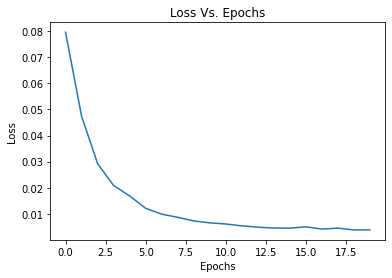

In [11]:
plt.plot(range(num_epochs),Losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs. Epochs')
plt.savefig('Autoencoder_Tanh_1.png')

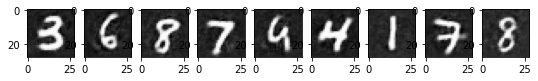

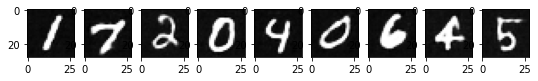

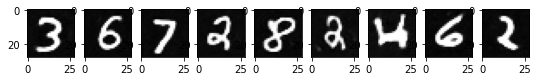

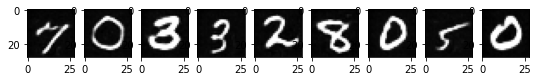

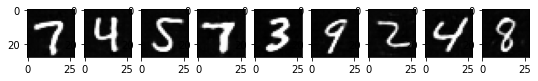

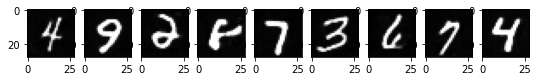

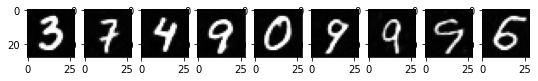

In [12]:
for k in range(0,num_epochs,3):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    reconstruct = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9,i+1)
        item = item.reshape(-1,28,28)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstruct):
        if i>=9 : break
        plt.subplot(2,9,i+1)
        item = item.reshape(-1,28,28)
        plt.imshow(item[0])

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
def validation_step(FC,data,label):
    out = FC(data)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}

def validation_epoch_end(outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()} 

def epoch_end(epoch,result):
    print("====> Epoch [{}]  val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## 1 **FC** Layer

In [15]:
FC = Fullyconnected()
learning_rate = 0.001
optimizerFC = torch.optim.Adam(FC.parameters(),lr=learning_rate)
num_epochs_fc = 20

In [16]:
history = []
for epoch in range(num_epochs_fc):
    for batch in train_dl:
        img,label = batch
        noise_img = AddSaltPepperNosie(img,batch_size)
        encoded_img = model(noise_img,mode='encode')
        output = FC(encoded_img)
        loss = F.cross_entropy(output,label)
        loss.backward()
        optimizerFC.step()
        optimizerFC.zero_grad()
    
    # Evaluation
    encod_img = []
    labels = []
    for batch in val_dl:
        img,true_label = batch
        encod = model(img,mode='encode')
        encod_img.append(encod)
        labels.append(true_label)
    val_pred = []
    for i in range(90):
        val_pred.append(validation_step(FC,encod_img[i],labels[i])) 
    
    results = validation_epoch_end(val_pred)
    history.append(results)
    epoch_end(epoch,results)  

====> Epoch [0]  val_loss: 2.1196, val_acc: 0.6757
====> Epoch [1]  val_loss: 1.9427, val_acc: 0.7214
====> Epoch [2]  val_loss: 1.8460, val_acc: 0.7626
====> Epoch [3]  val_loss: 1.7854, val_acc: 0.7951
====> Epoch [4]  val_loss: 1.7473, val_acc: 0.8109
====> Epoch [5]  val_loss: 1.7221, val_acc: 0.8203
====> Epoch [6]  val_loss: 1.7030, val_acc: 0.8273
====> Epoch [7]  val_loss: 1.6893, val_acc: 0.8341
====> Epoch [8]  val_loss: 1.6782, val_acc: 0.8359
====> Epoch [9]  val_loss: 1.6679, val_acc: 0.8443
====> Epoch [10]  val_loss: 1.6612, val_acc: 0.8450
====> Epoch [11]  val_loss: 1.6548, val_acc: 0.8476
====> Epoch [12]  val_loss: 1.6481, val_acc: 0.8529
====> Epoch [13]  val_loss: 1.6430, val_acc: 0.8567
====> Epoch [14]  val_loss: 1.6397, val_acc: 0.8563
====> Epoch [15]  val_loss: 1.6356, val_acc: 0.8582
====> Epoch [16]  val_loss: 1.6316, val_acc: 0.8590
====> Epoch [17]  val_loss: 1.6292, val_acc: 0.8625
====> Epoch [18]  val_loss: 1.6256, val_acc: 0.8641
====> Epoch [19]  val_

In [17]:
validation_loss_fc1 = [x['val_loss'] for x in history]
validation_acc_fc1 = [x['val_acc'] for x in history]

## 3 **FC** Layer

In [18]:
FC3 = Fullyconnected3()
learning_rate = 0.001
optimizerFC = torch.optim.Adam(FC3.parameters(),lr=learning_rate)
num_epochs_fc = 20

In [19]:
history = []
for epoch in range(num_epochs_fc):
    for batch in train_dl:
        img,label = batch
        noise_img = AddSaltPepperNosie(img,batch_size)
        encoded_img = model(noise_img,mode='encode')
        output = FC3(encoded_img)
        loss = F.cross_entropy(output,label)
        loss.backward()
        optimizerFC.step()
        optimizerFC.zero_grad()
    
    # Evaluation
    encod_img = []
    labels = []
    for batch in val_dl:
        img,true_label = batch
        encod = model(img,mode='encode')
        encod_img.append(encod)
        labels.append(true_label)
    val_pred = []
    for i in range(90):
        val_pred.append(validation_step(FC3,encod_img[i],labels[i]))
    
    results = validation_epoch_end(val_pred)
    history.append(results)
    epoch_end(epoch,results)

====> Epoch [0]  val_loss: 1.7305, val_acc: 0.8008
====> Epoch [1]  val_loss: 1.6239, val_acc: 0.8782
====> Epoch [2]  val_loss: 1.5807, val_acc: 0.9029
====> Epoch [3]  val_loss: 1.5615, val_acc: 0.9181
====> Epoch [4]  val_loss: 1.5520, val_acc: 0.9234
====> Epoch [5]  val_loss: 1.5438, val_acc: 0.9298
====> Epoch [6]  val_loss: 1.5378, val_acc: 0.9322
====> Epoch [7]  val_loss: 1.5356, val_acc: 0.9344
====> Epoch [8]  val_loss: 1.5321, val_acc: 0.9356
====> Epoch [9]  val_loss: 1.5281, val_acc: 0.9402
====> Epoch [10]  val_loss: 1.5278, val_acc: 0.9393
====> Epoch [11]  val_loss: 1.5264, val_acc: 0.9390
====> Epoch [12]  val_loss: 1.5243, val_acc: 0.9411
====> Epoch [13]  val_loss: 1.5221, val_acc: 0.9431
====> Epoch [14]  val_loss: 1.5208, val_acc: 0.9445
====> Epoch [15]  val_loss: 1.5206, val_acc: 0.9448
====> Epoch [16]  val_loss: 1.5186, val_acc: 0.9463
====> Epoch [17]  val_loss: 1.5167, val_acc: 0.9482
====> Epoch [18]  val_loss: 1.5156, val_acc: 0.9499
====> Epoch [19]  val_

In [20]:
validation_loss_fc3 = [x['val_loss'] for x in history]
validation_acc_fc3 = [x['val_acc'] for x in history]

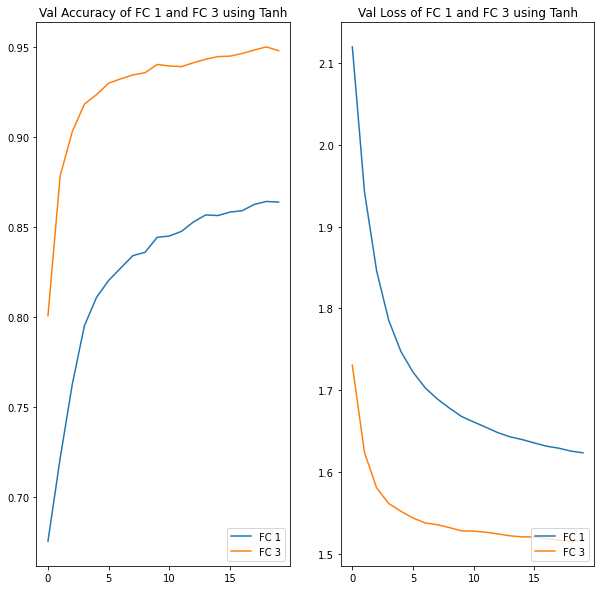

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs_fc), validation_acc_fc1, label='FC 1')
plt.plot(range(num_epochs_fc), validation_acc_fc3, label='FC 3')
plt.legend(loc='lower right')
plt.title('Val Accuracy of FC 1 and FC 3 using Tanh')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs_fc), validation_loss_fc1, label='FC 1')
plt.plot(range(num_epochs_fc), validation_loss_fc3, label='FC 3')
plt.legend(loc='lower right')
plt.title('Val Loss of FC 1 and FC 3 using Tanh')
plt.show()
plt.savefig('Autoencoder_Tanh_Noisy.png')